In [19]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.contingency_tables import StratifiedTable
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

In [20]:
df = pd.read_csv('hw_aa.csv', sep=';')
df.drop(columns=['Unnamed: 0'], inplace=True)
df

,uid,experimentVariant,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...
127013,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127014,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127015,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127016,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


Смотрим, типы колонок и есть ли отсутствующие значения 

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127018 entries, 0 to 127017
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   uid                127018 non-null  object
 1   experimentVariant  127018 non-null  int64 
 2   version            127018 non-null  object
 3   purchase           127018 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.9+ MB


Делим набор на группы

In [22]:
a1 = df.query('experimentVariant == 0')
a2 = df.query('experimentVariant == 1')

Посмотрим на эти подгруппы

In [23]:
a1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63102 entries, 1 to 127014
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   uid                63102 non-null  object
 1   experimentVariant  63102 non-null  int64 
 2   version            63102 non-null  object
 3   purchase           63102 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.4+ MB


In [24]:
a2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63916 entries, 0 to 127017
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   uid                63916 non-null  object
 1   experimentVariant  63916 non-null  int64 
 2   version            63916 non-null  object
 3   purchase           63916 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.4+ MB


In [25]:
print('Доля наблюдений в первом наборе:', round(a1.shape[0] / df.shape[0] * 100, 2))
print('Доля наблюдений во втором наборе:', round(a2.shape[0] / df.shape[0] * 100, 2))

Доля наблюдений в первом наборе: 49.68
Доля наблюдений во втором наборе: 50.32


Количество наблюдений в этих группах немного различаются. Проведем A/A тест

In [26]:
def aa_test(a1, a2, simulations = 1000, n_s = 1000, alpha = 0.05):
    res = []

    # Запуск симуляций A/A теста
    for i in tqdm(range(simulations)):
        s1 = a1.sample(n_s, replace = False).values
        s2 = a2.sample(n_s, replace = False).values
        res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

    plt.hist(res, bins = 50)
    plt.style.use('ggplot')
    plt.xlabel('pvalues')
    plt.ylabel('frequency')
    plt.title("Histogram of ttest A/A simulations ")
    plt.show()

    # Проверяем, что количество ложноположительных случаев не превышает альфа
    print(sum(np.array(res) < alpha) / simulations)

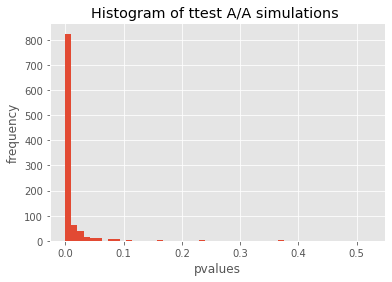

0.95


In [27]:
aa_test(a1['purchase'], a2['purchase'])

В результате проведенного теста p-value сильно больше уровня $\alpha$ ($\alpha=0.05$). Попробуем найти причины поломки системы сплитования

In [28]:
df_uid_count = df.groupby(['experimentVariant', 'version'], as_index=False) \
                 .agg({'uid': 'count'})
df_uid_count

,experimentVariant,version,uid
0,0,v2.8.0,41283
1,0,v2.9.0,11921
2,0,v3.7.4.0,4204
3,0,v3.8.0.0,5694
4,1,v2.8.0,41552
5,1,v2.9.0,12033
6,1,v3.7.4.0,4221
7,1,v3.8.0.0,6110


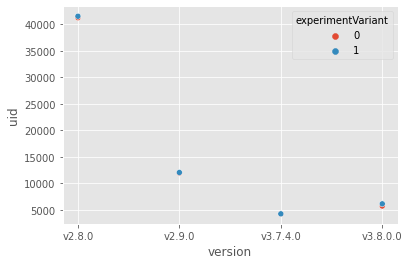

In [29]:
sns.scatterplot(x='version', y='uid', hue='experimentVariant', data=df_uid_count)

Распределение количества пользователей по версиям между группами выглядит похожим образом и явного дисбаланса не наблюдается

Посмотрим распределение суммы заказов в этих группах

In [30]:
df_purchase_sum = df.groupby(['experimentVariant', 'version'], as_index=False) \
                    .agg({'purchase': 'sum'})
df_purchase_sum

,experimentVariant,version,purchase
0,0,v2.8.0,41
1,0,v2.9.0,890
2,0,v3.7.4.0,252
3,0,v3.8.0.0,328
4,1,v2.8.0,1895
5,1,v2.9.0,858
6,1,v3.7.4.0,266
7,1,v3.8.0.0,384


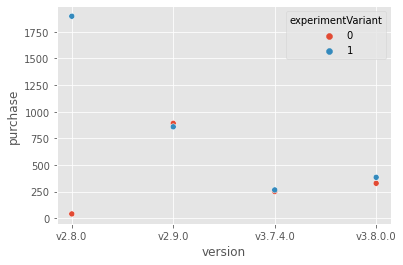

In [31]:
sns.scatterplot(x='version', y='purchase', hue='experimentVariant', data=df_purchase_sum)

Для версии 2.8.0 видны сильные различия в сумме заказов. Посчитаем конверсию

In [32]:
df_conversion = df.groupby(['experimentVariant', 'version'], as_index=False) \
                  .agg({'uid': 'count', 'purchase': 'sum'})
df_conversion['conversion'] = df_conversion['purchase'] / df_conversion['uid']
df_conversion

,experimentVariant,version,uid,purchase,conversion
0,0,v2.8.0,41283,41,0.000993
1,0,v2.9.0,11921,890,0.074658
2,0,v3.7.4.0,4204,252,0.059943
3,0,v3.8.0.0,5694,328,0.057604
4,1,v2.8.0,41552,1895,0.045606
5,1,v2.9.0,12033,858,0.071304
6,1,v3.7.4.0,4221,266,0.063018
7,1,v3.8.0.0,6110,384,0.062848


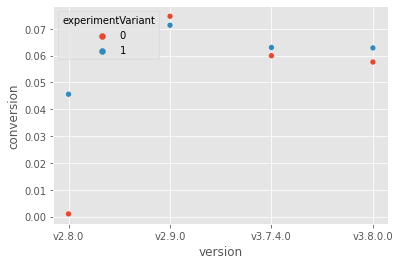

In [33]:
sns.scatterplot(x='version', y='conversion', hue='experimentVariant', data=df_conversion)

Конверсия для версии 2.8.0 также сильно различаются между группами. Проверим это ещё и с помощью построения StratifiedTable

In [34]:
StratifiedTable.from_data('experimentVariant', 'purchase', 'version', df).summary()

,Estimate,LCB,UCB
Pooled odds,2.300,2.161,2.447
Pooled log odds,0.833,0.771,0.895
Pooled risk ratio,1.031,,
,,,
,Statistic,P-value,
Test of OR=1,734.655,0.000,
Test constant OR,1256.880,0.000,
,,,
Number of tables,4,,
Min n,8425,,


В получившейся таблице также видно, что присутствуют значимые различия между стратами (версиями).

Также проведем A/A тест для каждой из версий

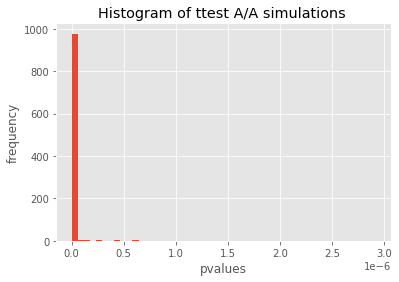

1.0


In [36]:
aa_test(a1.query('version == "v2.8.0"')['purchase'], a2.query('version == "v2.8.0"')['purchase'])

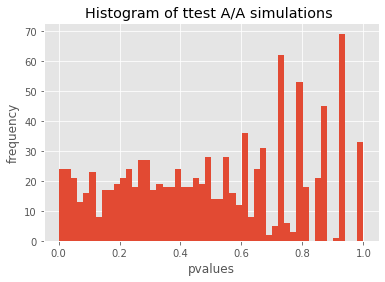

0.058


In [37]:
aa_test(a1.query('version == "v2.9.0"')['purchase'], a2.query('version == "v2.9.0"')['purchase'])

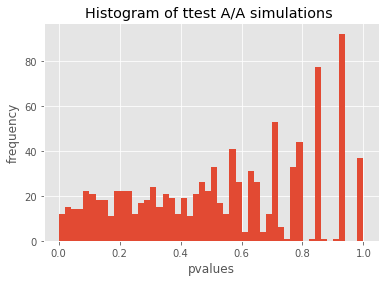

0.035


In [38]:
aa_test(a1.query('version == "v3.7.4.0"')['purchase'], a2.query('version == "v3.7.4.0"')['purchase'])

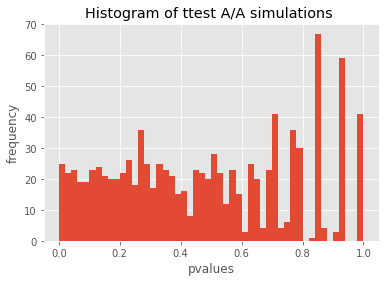

0.057


In [39]:
aa_test(a1.query('version == "v3.8.0.0"')['purchase'], a2.query('version == "v3.8.0.0"')['purchase'])

Выбросим версию (v.2.8.0) из наборов и проведем ещё раз A/A тест

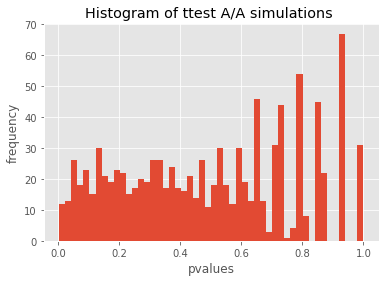

0.037


In [17]:
aa_test(a1.query('version != "v2.8.0"')['purchase'], a2.query('version != "v2.8.0"')['purchase'])

После исключения версии из наборов, p-value в результате проведенного A/A теста стало меньше чем 0.05, что может говорить нам о том, что проблема действительно, скорее всего именно в версии v.2.8.0. Посмотрим ещё раз на этот результат с помощью StratifiedTable

In [18]:
StratifiedTable.from_data('experimentVariant', 'purchase', 'version', df.query('version != "v2.8.0"')).summary()

,Estimate,LCB,UCB
Pooled odds,1.003,0.931,1.080
Pooled log odds,0.003,-0.072,0.077
Pooled risk ratio,1.000,,
,,,
,Statistic,P-value,
Test of OR=1,0.005,0.944,
Test constant OR,2.766,0.251,
,,,
Number of tables,3,,
Min n,8425,,


Значимых различий между версиями не удалось обнаружить, согласно результатам p-value при прстроении стратифицирующей таблицы

**Выводы**

A/A тест в данном случае помог найти поломку в системе сплитования. Хоть и количетсво пользователей для версий в различных группах были примерно одинаково, количество покупок (и исходя из этого сама конверсия) резко различались, что удалось обнаружить при более тщательном рассмотрении данных, а также при построении стратифицирующей таблицы.

При исключении найденной проблемной версии (v2.8.0), на основе проведенных тестов можно сказать, что на оставшихся данных сплитовалка хорошо работает, и что деление на группы позволяет адекватно оценивать дальнейшие эксперименты (например, A/B тесты).